Training des Modells...


Training boosting rounds: 100%|██████████████| 500/500 [00:01<00:00, 425.84it/s]


Berechne Permutation Importance auf den Trainingsdaten...


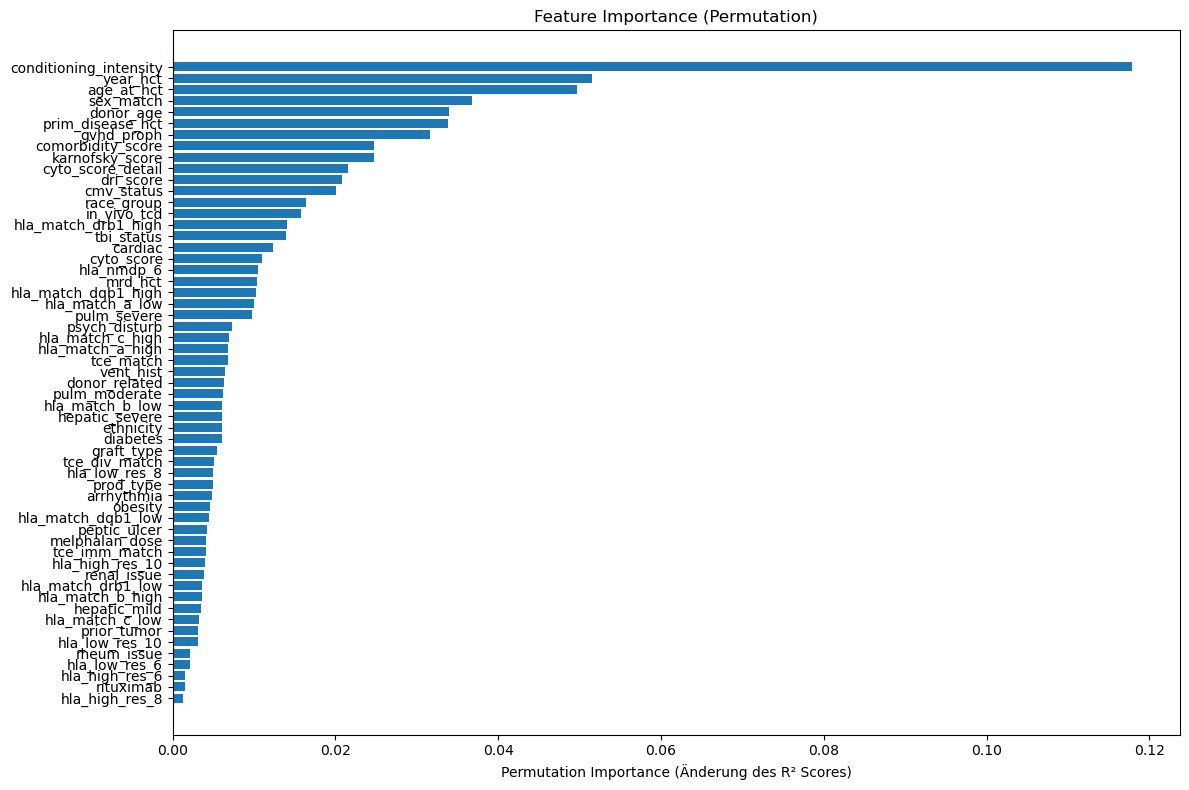

Vorhersagen für Testdaten...
✅ Ergebnisse wurden erfolgreich gespeichert: results.csv


In [6]:
import os
import pandas as pd
import numpy as np
import xgboost as xgb
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance
from sklearn.metrics import r2_score

def clean_data(df, is_train=True):
    """
    Bereinigt den DataFrame:
      - Ersetzt fehlende Werte (NaN) mit Standardwerten.
      - Entfernt problematische Zeichen aus Spaltennamen.
      - Wandelt kategorische Spalten in numerische Werte um.
    """
    df.fillna(0, inplace=True)
    df.columns = df.columns.str.replace(r"[^a-zA-Z0-9_]", "_", regex=True)
    for col in df.columns:
        if df[col].dtype == 'object':
            df[col] = df[col].astype(str).astype('category').cat.codes
    return df

class TqdmCallback(xgb.callback.TrainingCallback):
    def __init__(self, pbar):
        self.pbar = pbar

    def after_iteration(self, model, epoch, evals_log):
        self.pbar.update(1)
        return False  # Training wird fortgesetzt

class SklearnBoosterWrapper:
    """
    Dieser Wrapper macht den XGBoost-Booster sklearn-kompatibel, indem er:
      - eine Dummy-fit-Methode implementiert,
      - die predict-Methode überschreibt und die beim Training verwendeten Feature-Namen erzwingt,
      - sowie eine score-Methode (hier: R²-Score) bereitstellt.
    """
    def __init__(self, booster, feature_names):
        self.booster = booster
        self.feature_names = feature_names
        self.n_features_in_ = len(feature_names)
    
    def fit(self, X, y=None):
        return self  # Das Modell ist bereits trainiert
    
    def predict(self, X):
        # Erzwinge die gleiche Spaltenreihenfolge wie beim Training
        if hasattr(X, 'columns'):
            X = X[self.feature_names]
        dmatrix = xgb.DMatrix(X, feature_names=self.feature_names)
        return self.booster.predict(dmatrix)
    
    def score(self, X, y, sample_weight=None):
        y_pred = self.predict(X)
        return r2_score(y, y_pred, sample_weight=sample_weight)

def main():
    # Aktuelles Arbeitsverzeichnis abrufen
    current_dir = os.getcwd().replace("\\", "/")
    
    # Pfade zu den Daten
    train_path = os.path.join(current_dir, "data/train.csv")
    test_path = os.path.join(current_dir, "data/test.csv")
    
    # Daten einlesen
    df_train = pd.read_csv(train_path)
    df_test = pd.read_csv(test_path)
    
    # Daten bereinigen
    df_train = clean_data(df_train, is_train=True)
    df_test = clean_data(df_test, is_train=False)
    
    # Sicherstellen, dass df_train und df_test dieselben Spalten haben
    missing_cols = set(df_train.columns) - set(df_test.columns)
    for col in missing_cols:
        df_test[col] = 0
    extra_cols = set(df_test.columns) - set(df_train.columns)
    df_test = df_test.drop(columns=extra_cols)
    df_test = df_test[df_train.columns]
    
    # Entferne "ID" aus den Features (da es nur zur Identifikation dient)
    if "ID" in df_train.columns:
        df_train = df_train.drop(columns=["ID"])
    # Testdaten: ID getrennt abspeichern und anschließend die Spalte entfernen
    if "ID" in df_test.columns:
        test_ids = df_test["ID"]
        df_test = df_test.drop(columns=["ID"])
    else:
        test_ids = None
    
    # Features und Zielvariable definieren
    X_train = df_train.drop(columns=['efs', 'efs_time'], errors='ignore')
    y_train = df_train['efs']
    X_test = df_test.drop(columns=['efs', 'efs_time'], errors='ignore')
    
    # Nur numerische Spalten verwenden
    X_train = X_train.select_dtypes(include=[np.number])
    X_test = X_test.select_dtypes(include=[np.number])
    
    # Achte darauf, dass die DMatrix-Objekte die Feature-Namen enthalten
    feature_names = list(X_train.columns)
    dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=feature_names)
    dtest = xgb.DMatrix(X_test, feature_names=feature_names)
    
    # Parameter für das Training; 40 Kerne (nthread) nutzen
    params = {
        "objective": "reg:squarederror",
        "learning_rate": 0.05,
        "max_depth": 5,
        "nthread": 40,
        "seed": 42
    }
    num_boost_round = 500
    
    # Training des Modells mit einem Fortschrittsbalken über alle Boosting-Runden
    print("Training des Modells...")
    with tqdm(total=num_boost_round, desc="Training boosting rounds") as pbar:
        model = xgb.train(
            params,
            dtrain,
            num_boost_round=num_boost_round,
            callbacks=[TqdmCallback(pbar)]
        )
    
    # Den Booster in einen sklearn-kompatiblen Wrapper packen
    wrapper = SklearnBoosterWrapper(model, feature_names)
    
    # Berechnung der Permutation Importance auf den Trainingsdaten
    print("Berechne Permutation Importance auf den Trainingsdaten...")
    result = permutation_importance(wrapper, X_train, y_train, n_repeats=10, random_state=42)
    importances = result.importances_mean
    
    sorted_idx = np.argsort(importances)
    plt.figure(figsize=(12, 8))
    plt.barh(range(len(sorted_idx)), importances[sorted_idx], align='center')
    plt.yticks(range(len(sorted_idx)), np.array(feature_names)[sorted_idx])
    plt.xlabel("Permutation Importance (Änderung des R² Scores)")
    plt.title("Feature Importance (Permutation)")
    plt.tight_layout()
    plt.show()
    
    # Vorhersagen für die Testdaten
    print("Vorhersagen für Testdaten...")
    risk_scores = model.predict(dtest)
    
    if test_ids is not None:
        results = pd.DataFrame({'ID': test_ids, 'prediction': risk_scores})
    else:
        results = pd.DataFrame({'risk_score': risk_scores})
    results.to_csv(os.path.join(current_dir, "submission.csv"), index=False)
    print("✅ Ergebnisse wurden erfolgreich gespeichert: submission.csv")

if __name__ == "__main__":
    main()


In [ ]:

sub = pd.read_csv("/kaggle/input/equity-post-HCT-survival-predictions/sample_submission.csv")
sub.prediction = predictions
sub.to_csv("submission.csv",index=False)
print("Sub shape:",sub.shape)
sub.head()
